In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

mycolors = ['#570f6d', '#bb3754', '#f98e08']

the number of bins is 100


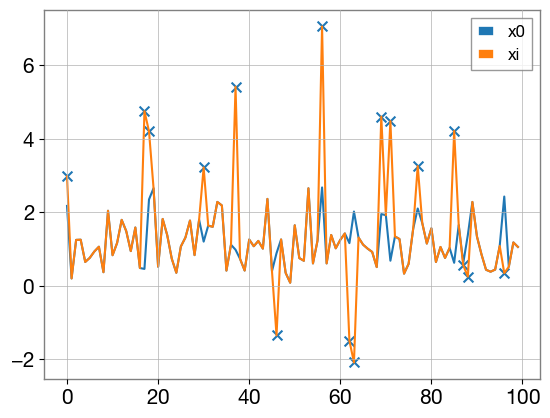

In [2]:
Nsims = 100_000
Nbins = 100
SIGMA = 1 # Likelihood covariance \Sigma = sigma * \mathbb{1}
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.2, bkg=True, dtype=torch.float32, mode='complex')     
samples = simulator.sample(Nsims=Nsims)  

plt.plot(samples['x0'][0], label='x0')
plt.plot(samples['xi'][0], label='xi')
idx = torch.where(samples['ni'][0] != 0)
plt.scatter(idx, samples['xi'][0][idx], marker='x', s=50)
plt.legend();

In [3]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [4]:
# # Train
# def resample(sample):
#     sample = simulator._resample(sample)
#     sample['x'] = sample['xi']
#     # sample = {k: v[0] for k, v in sample.items()}
#     return sample

# batch_size = 32
# samples = simulator.sample(Nsims=Nsims)  
# # dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
# dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
# network_epsilon = Network_epsilon()
# model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
# trainer = pl.Trainer(
#     accelerator="gpu", 
#     max_epochs=20, 
#     precision=64,
#     # fast_dev_run=True
# )
# trainer.fit(model, dm)
# network_epsilon.cuda().eval();

In [5]:
# torch.save(network_epsilon, 'networks/network_epsilon_complex')
# torch.save(model, 'networks/model_complex')

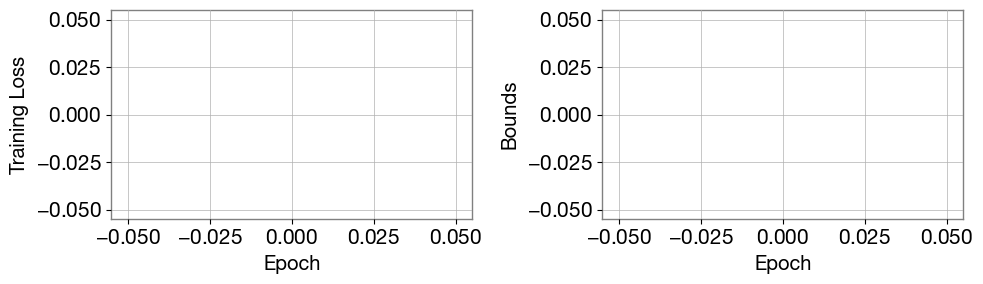

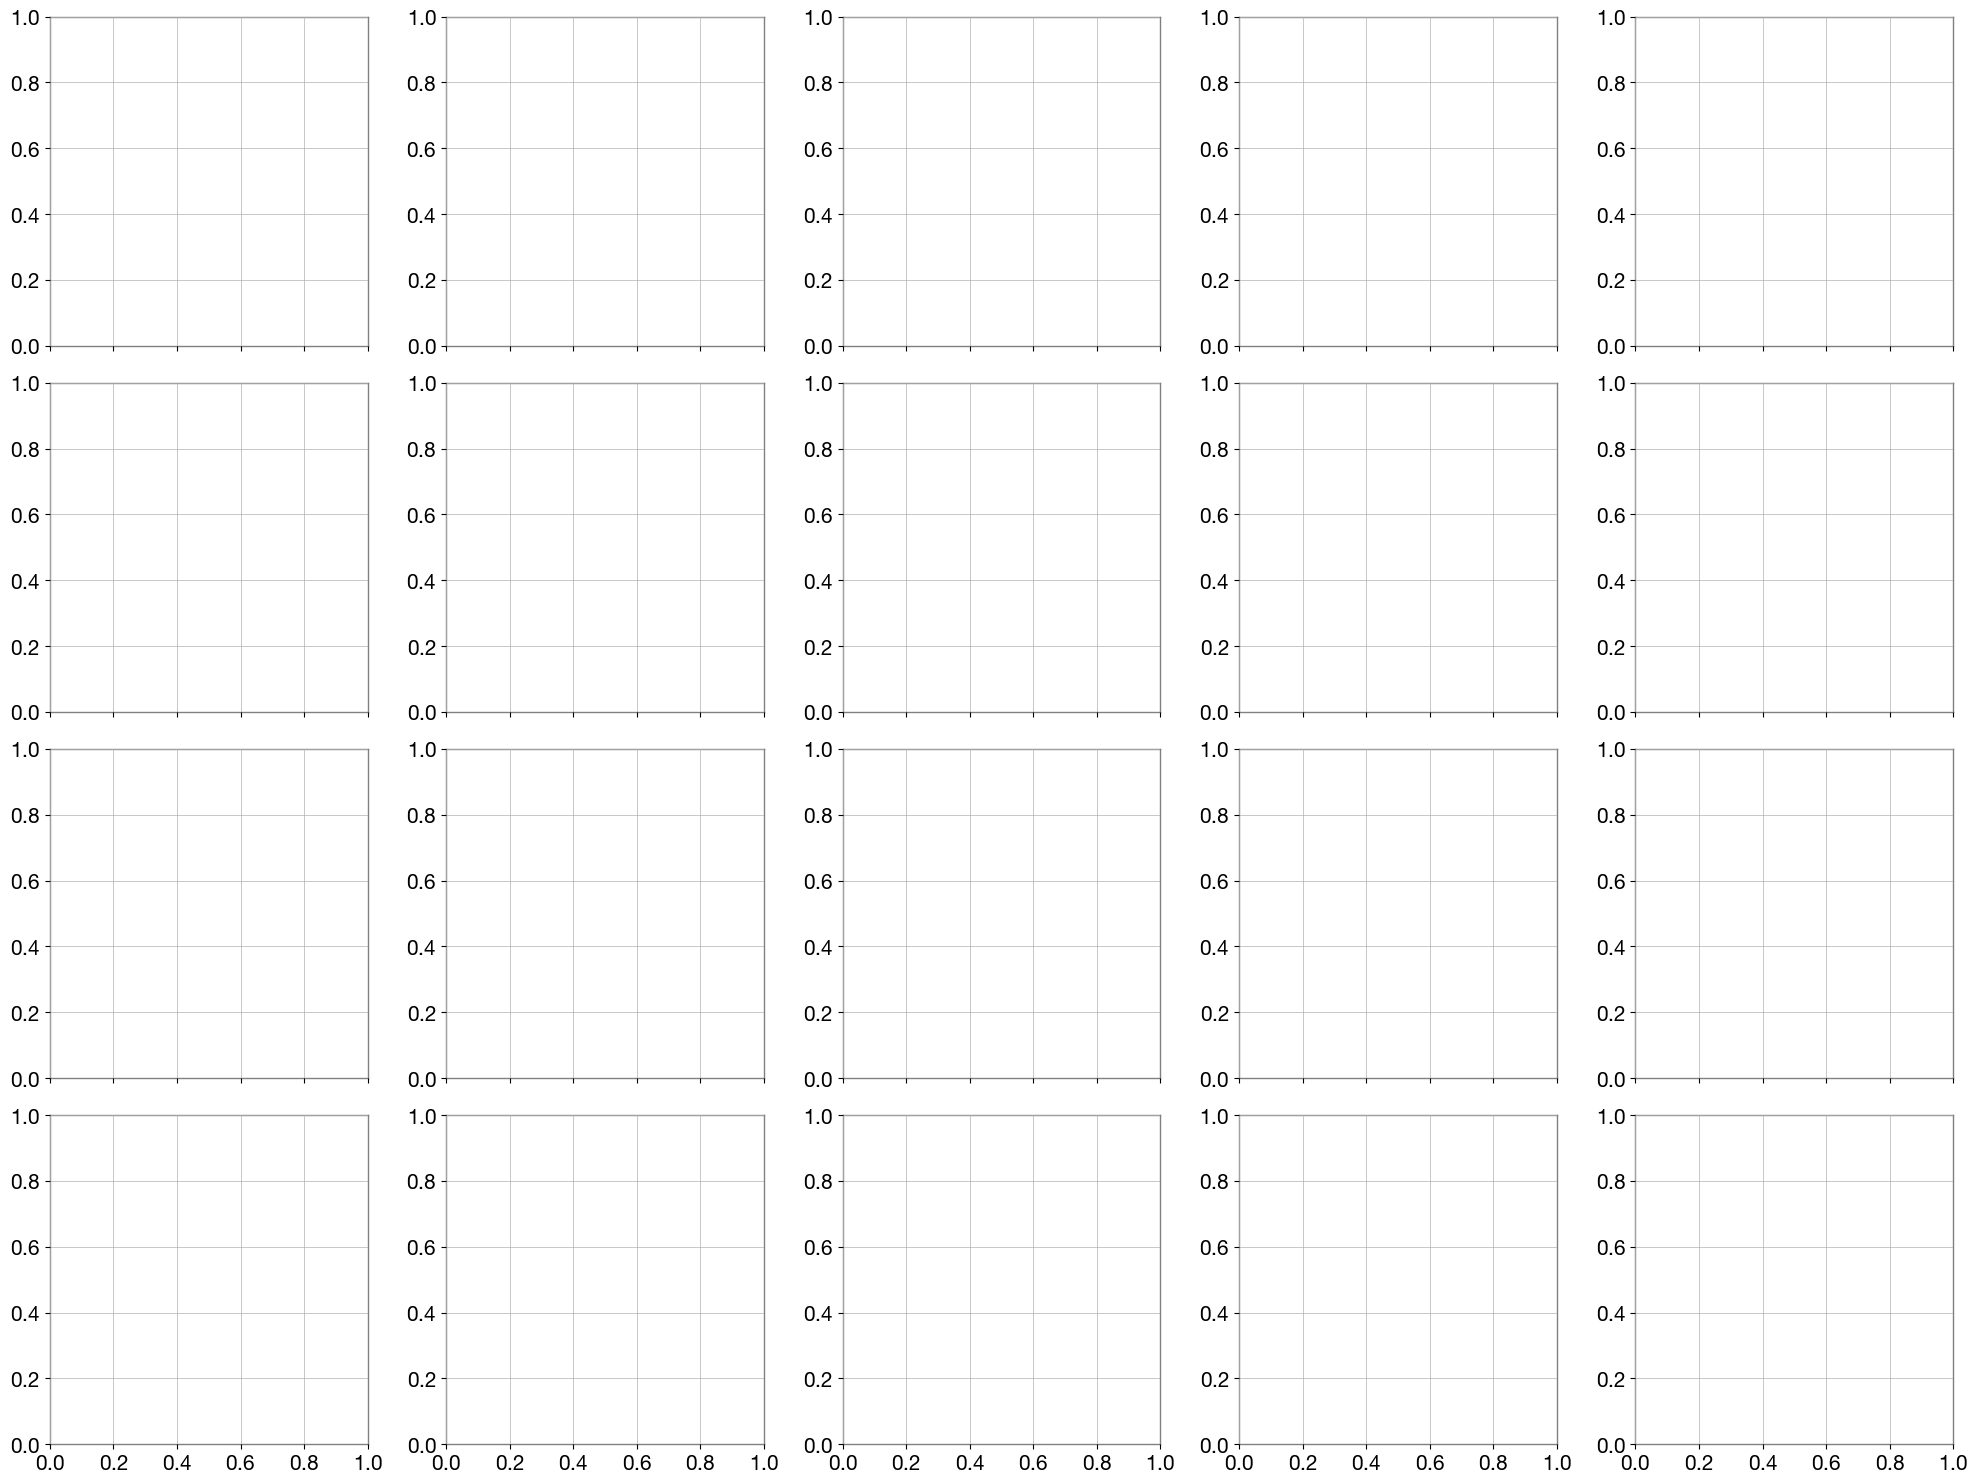

In [6]:
network_epsilon = Network_epsilon()
checkpoint = torch.load('networks/network_epsilon_complex', weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
network_epsilon.load_state_dict(new_state_dict)
# network_epsilon.cuda().double().eval()
network_epsilon.to(dtype=torch.float32,device='mps').eval()

model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
checkpoint = torch.load('networks/model_complex', weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
# new_state_dict = {}
# for key in sd:
#     new_key = key.replace('model.', '')  # Remove 'model.' prefix
#     new_state_dict[new_key] = sd[key]
    
model.load_state_dict(sd)
# network_epsilon.cuda().double().eval()
model.to(dtype=torch.float32,device='mps').eval()

# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout();

network_epsilon.bounds()

# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            # axs[i_b].plot(sample['mu'][0].cpu(), c='k', ls='--')
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
plt.tight_layout();

In [7]:
bounds = network_epsilon.bounds().detach().cpu().numpy()

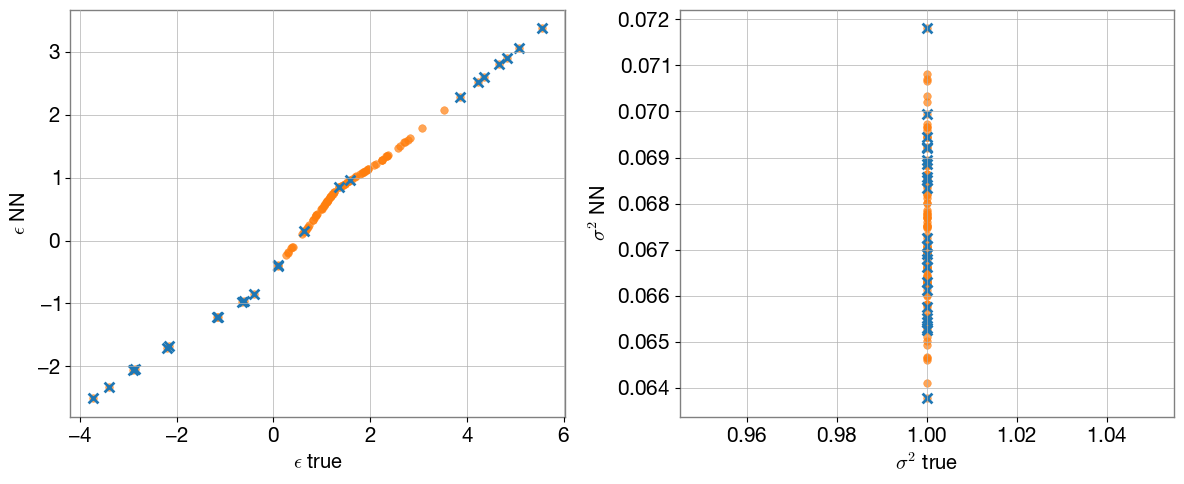

In [8]:
n = 50

obs = simulator.sample(1)  
delta_x = obs['xi']

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
epsilon_nn_obs = network_epsilon.epsilon(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
snr_nn_obs = network_epsilon.snr(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
# epsilon_nn_obs = network_epsilon.epsilon(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
# variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
# snr_nn_obs = network_epsilon.snr(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
epsilon_obs = get_epsilon(delta_x, ni).squeeze(0)
variance_obs = 1 / get_sigma_epsilon_inv2(ni)
snr_obs = get_snr(delta_x, ni).squeeze(0)

epsilon_nn_obs = network_epsilon.epsilon(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
snr_nn_obs = network_epsilon.snr(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)

# For each simultion of the n ones, compute analytical quantities
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(x=epsilon_obs, y=epsilon_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
axs[1].scatter(x=variance_obs, y=variance_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
    
idx = torch.where(obs['ni']==1)[1]
axs[0].scatter(x=epsilon_obs[idx], y=epsilon_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)
axs[1].scatter(x=variance_obs[idx], y=variance_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)

axs[0].set_xlabel(r'$\epsilon$ true')
axs[0].set_ylabel(r'$\epsilon$ NN')
axs[1].set_xlabel(r'$\sigma^2$ true')
axs[1].set_ylabel(r'$\sigma^2$ NN')
plt.tight_layout();

In [9]:
N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
# ts_bin_H0_epsilon = []
# for _ in tqdm(range(N_batch)):
#     mc_samples = simulator.sample(batch_size)
#     ts_batch =  (network_epsilon.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
#     ts_bin_H0_epsilon.append(ts_batch)
    
# ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)
# ts_bin_H0_epsilon.shape
# np.save('mc_bin/ts_bin_H0_epsilon_complex',ts_bin_H0_epsilon)

ts_bin_H0_epsilon = np.load('mc_bin/ts_bin_H0_epsilon_complex.npy')

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/3226281772.py:12: SyntaxWarning: invalid escape sequence '\c'
  axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')


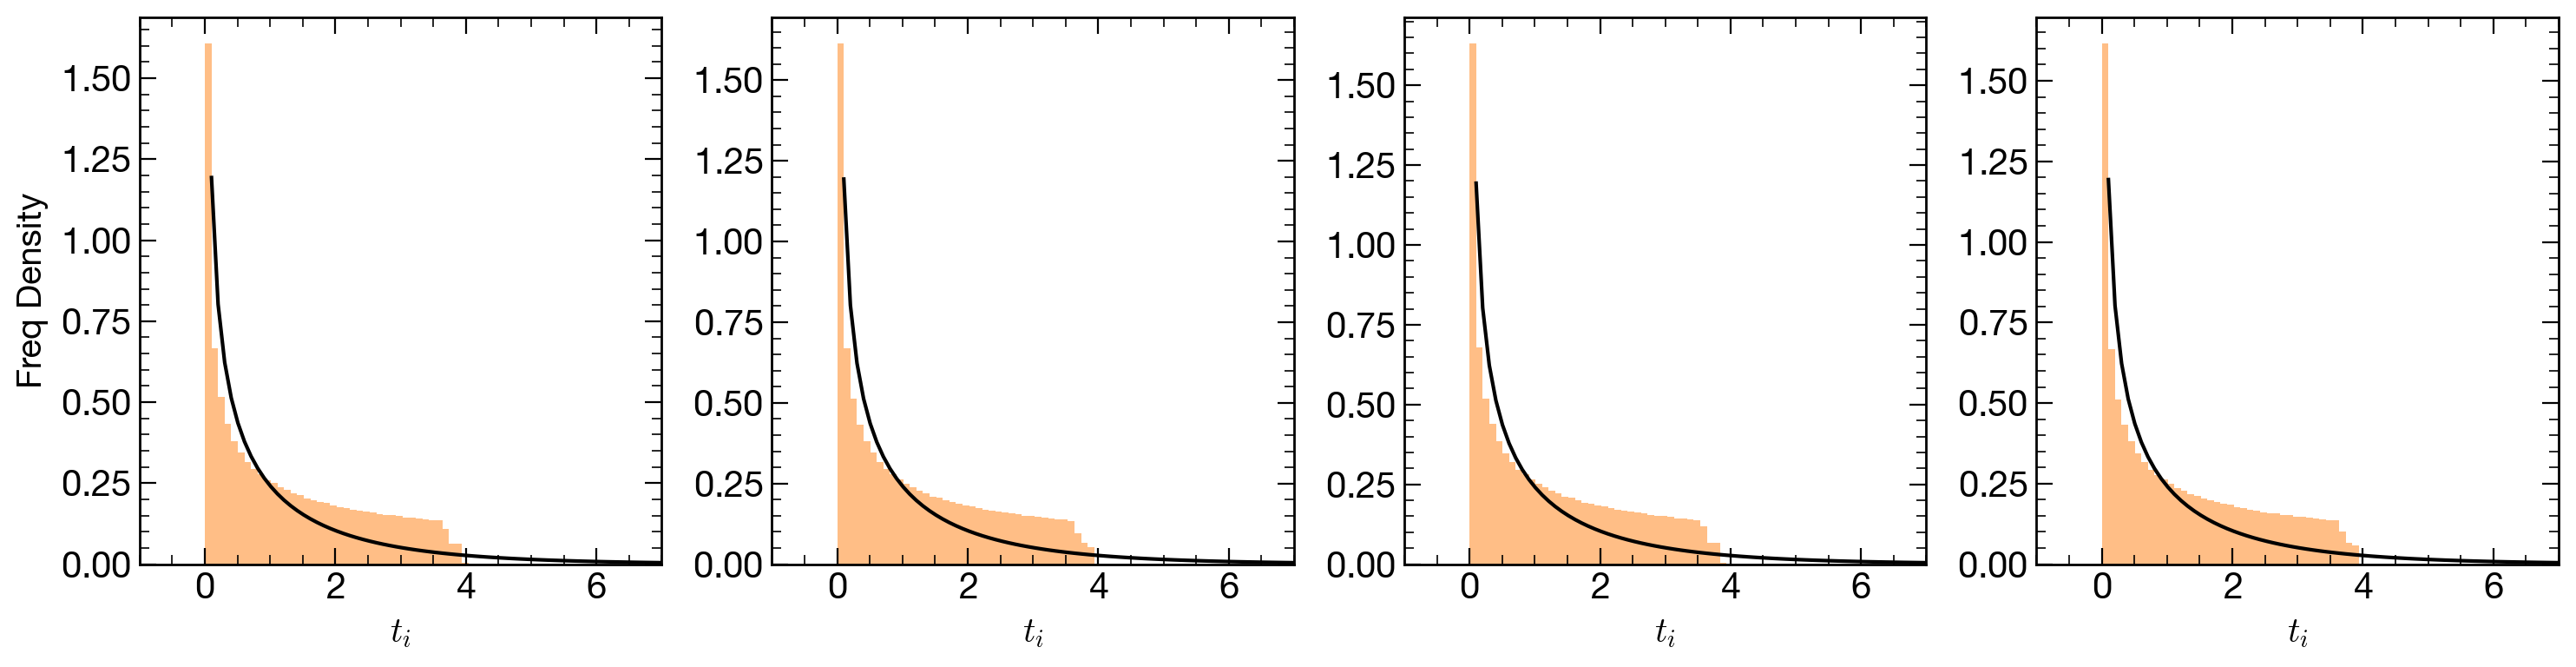

In [10]:

grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

fig, axs = plt.subplots(1, 4, figsize=(15, 4), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_epsilon[:, bin]
    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-1, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')
axs[0].set_ylabel('Freq Density')

pf.fix_plot(axs)

plt.tight_layout()
plt.savefig('figs/histogram_complex.png', dpi=300)

<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/361536634.py:84: SyntaxWarning: invalid escape sequence '\m'
  axs[3, 0].set_ylabel("$\mathrm{p}_i$")


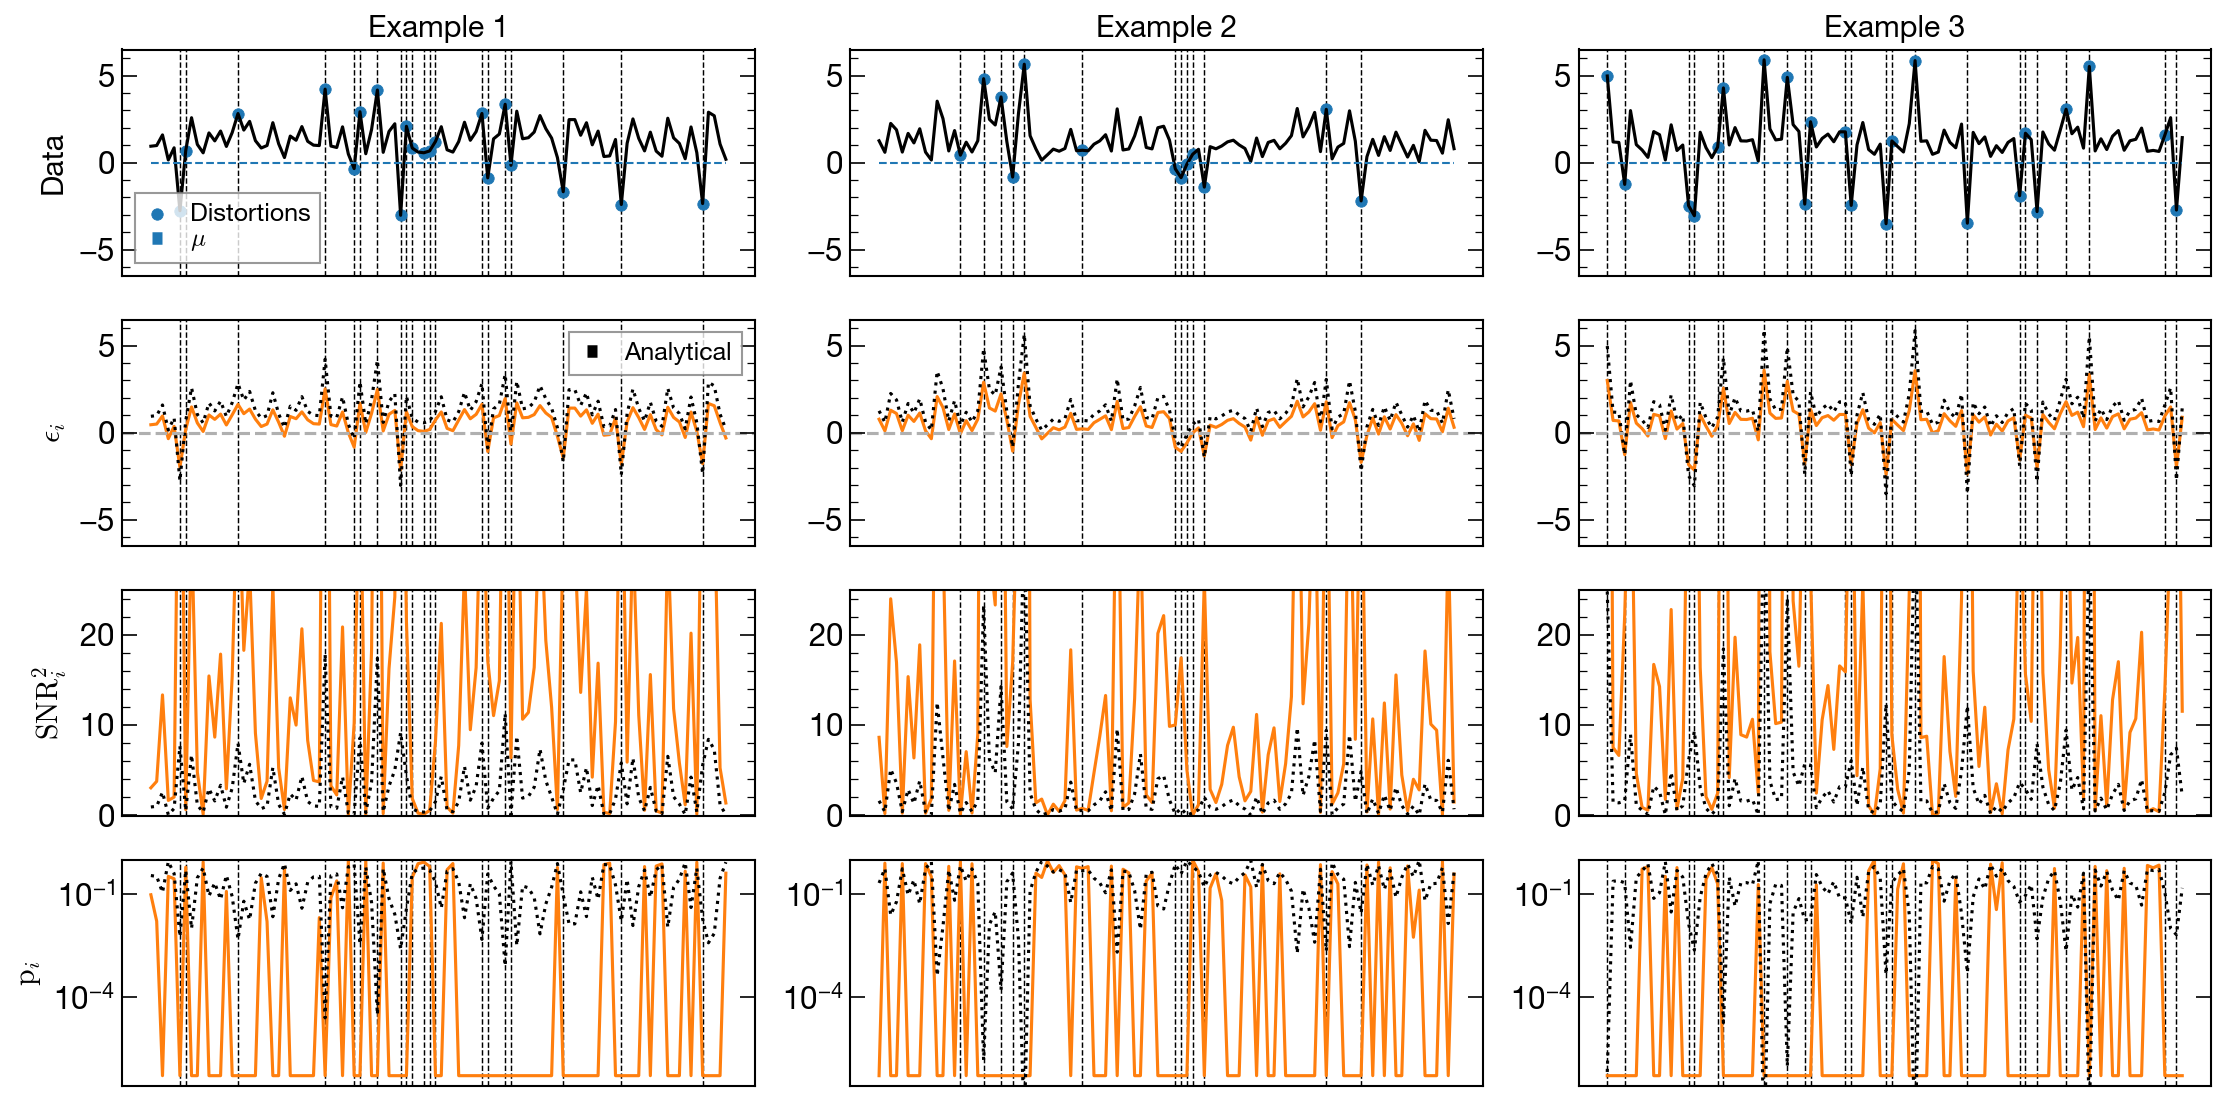

In [11]:
#### NOTE - MIST GOF LIBRARY DOESN'T EXIST - TAKING A GUESS AT HOW THESE FUNCTIONS WORK ####
def t_to_pvalue(ts, df=1):
    return 1 - scipy.stats.chi2.cdf(ts, df)

def t_to_pvalue_empirical(ts_obs, ts0_ref):
    ts0_ref = np.asarray(ts0_ref)
    return (np.sum(ts0_ref >= ts_obs) + 1) / (len(ts0_ref) + 1)


### - NOEMI'S CODE - ###
fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
for i in range(3):
    
    ### - GET SAMPLE - ###
    obs = simulator.sample(1) 
    
    ### - GET NN EPS AND SNR - ###
    epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2
    
    ### - ANALYTICAL COMPUTE SNR AND EPS - ###
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = obs['xi'] - fit
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2

    ### - COMPUTE P VALUES - ###
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 dof per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    ### - PLOT - ###
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid, epsilon_nn, c='C1')
    axs[1, i].plot(grid, epsilon_analytical, c='k', ls='dotted', label='Analytical')
    axs[1, i].set_ylim(-6.5, 6.5)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])
    
    axs[2, i].plot(grid, snr2_nn, c='C1')
    axs[2, i].plot(grid, snr2_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(-0.1, 25)
    axs[2, i].set_xticks([])

    axs[3, i].semilogy(grid, p_nn, c='C1')
    axs[3, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[3, i].set_ylim(1/N_mc/2, 1)
    axs[3, i].grid(True, axis='y')
    axs[3, i].set_xticks([])

    distortion_locations = grid[ni != 0]
    for plot_row in axs[:, i]:
        for loc in distortion_locations:
                plot_row.axvline(loc, color='black', linestyle='--', lw=0.7, zorder=-1)

    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$\epsilon_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_i$")
axs[3, 0].set_ylabel("$\mathrm{p}_i$")
for ax in axs:
    pf.fix_plot(ax)
plt.tight_layout();


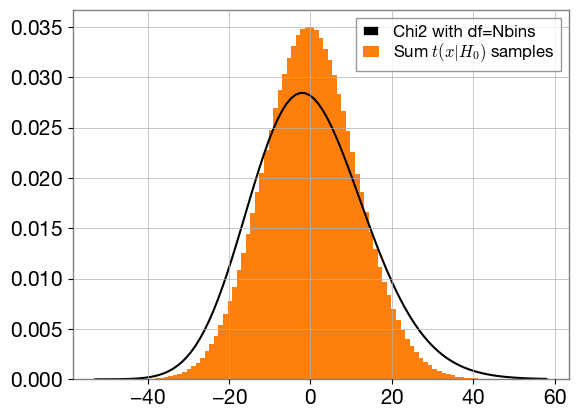

In [12]:
DOF = Nbins

# From MCMC samples
ts_sum_H0_epsilon = ts_bin_H0_epsilon.sum(axis=1)
ts_sum_H0_epsilon_mean = ts_sum_H0_epsilon.mean()
ts_sum_H0_epsilon = ts_sum_H0_epsilon - ts_sum_H0_epsilon_mean

# Plot
plt.figure()
bins = np.linspace(ts_sum_H0_epsilon.min(), ts_sum_H0_epsilon.max(), 100)
plt.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label='Chi2 with df=Nbins')
plt.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='C1', label='Sum $t(x|H_0)$ samples')
plt.legend(loc='best', fontsize=12, labelspacing=0.1);

<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/2551355674.py:57: SyntaxWarning: invalid escape sequence '\e'
  axs[2, i].set_xlabel("$\epsilon / \sigma$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/2551355674.py:63: SyntaxWarning: invalid escape sequence '\m'
  axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/2551355674.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[2, i].hist(epsilon_analytical/np.sqrt(variance_analytical), bins=bins, density=True, color='k', alpha=0.4, label='Analytical')
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/2551355674.py:55: DeprecationWa

the number of bins is 100
the number of bins is 100
the number of bins is 100
the number of bins is 100


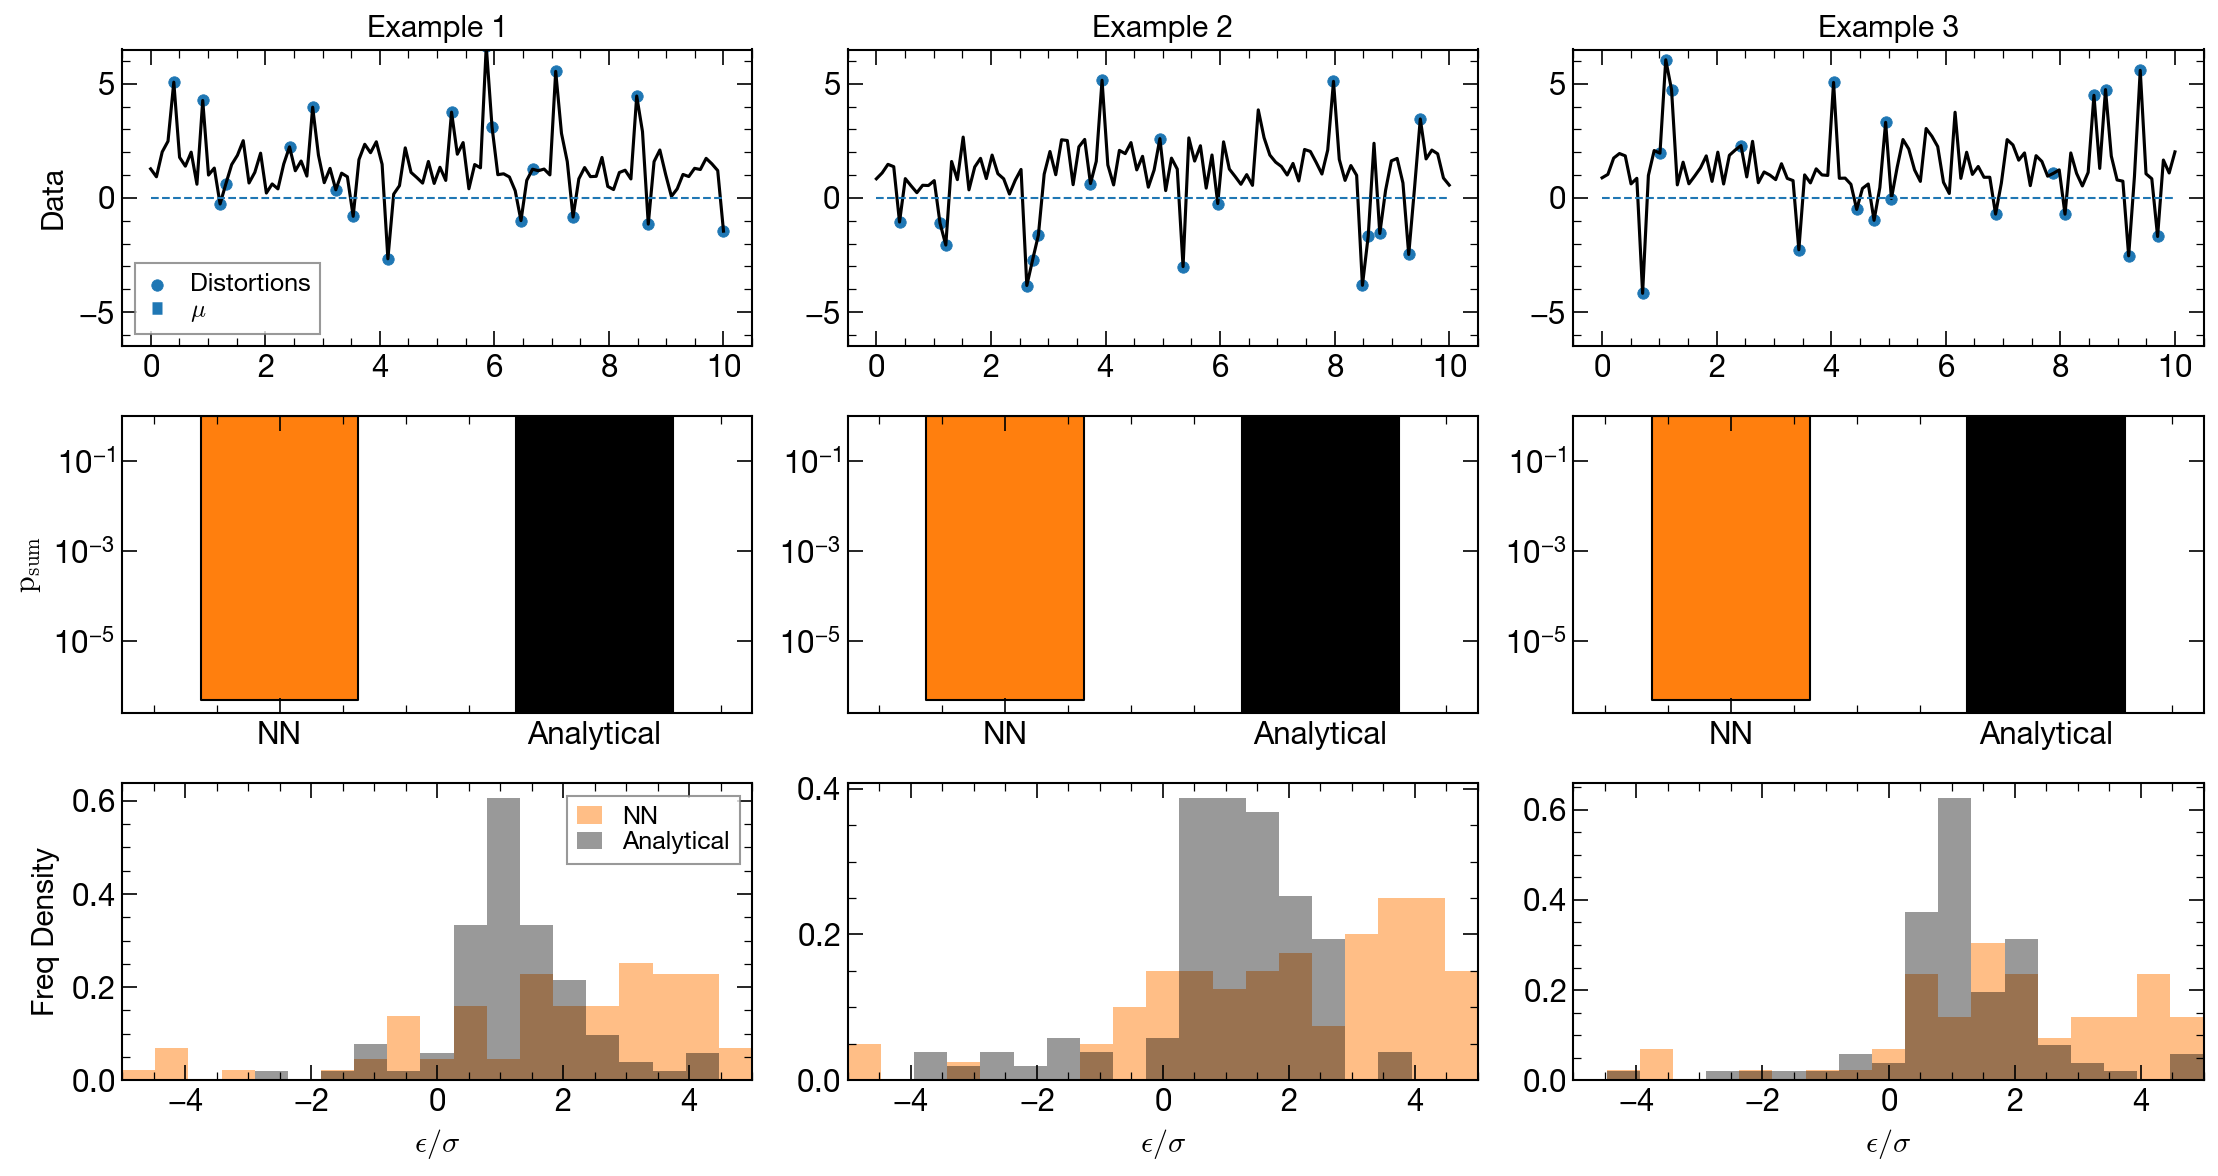

In [13]:
### - INITIALISE SIMULATOR - ###
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.2, bkg=True, dtype=torch.float32, mode='complex')     

fig, axs = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
for i in range(3):
    
    ### - GET A SAMPLE - ###
    simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.2, bkg=True, dtype=torch.float32, mode='complex')     
    obs = simulator1.sample(1) 
    
    ### - EVALUATE EPSILON AND SNR^2 FROM NN - ###
    epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
    # epsilon_nn = network_epsilon.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2
    # snr2_nn = network_epsilon.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2
    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()
    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   
    
    ### - COMPUTE ANALYTICALLY - ###
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = obs['xi'] - fit
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    variance_analytical = 1 / get_sigma_epsilon_inv2(ni_temp)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() - Nbins #((sample['xi'])**2/SIGMA**2).sum()-Nbins
    p_sum_analytical = t_to_pvalue(ts_sum_analytical+Nbins, Nbins)  
    
    ### - PLOT - ###
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xticks([0, 1])
    axs[1, i].set_xticklabels(['NN', 'Analytical'])
    axs[1, i].set_xlim(-0.5, 2 - 0.5)
    axs[1, i].grid(True)
    for x, value, color in zip([0, 1], [p_sum_nn, p_sum_analytical], ['C1', 'k']):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value, facecolor=color, edgecolor='black')
    
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    axs[2, i].hist(epsilon_nn/np.sqrt(variance_nn), bins=bins, density=True, color='C1', alpha=0.5, label='NN')
    axs[2, i].hist(epsilon_analytical/np.sqrt(variance_analytical), bins=bins, density=True, color='k', alpha=0.4, label='Analytical')
    axs[2, i].set_xlim(-5*SIGMA, 5*SIGMA)
    axs[2, i].set_xlabel("$\epsilon / \sigma$")
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")
axs[2, 0].set_ylabel('Freq Density')
axs[2, 0].legend(loc='best', fontsize=12, labelspacing=0.1)

for ax in axs:
    for a in ax:
        pf.fix_plot([a])
plt.tight_layout();

In [14]:
N_mc, num_bins = ts_bin_H0_epsilon.shape
ts_bin_flat = ts_bin_H0_epsilon.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    

pv_bin_H0.shape

(1998848, 100)

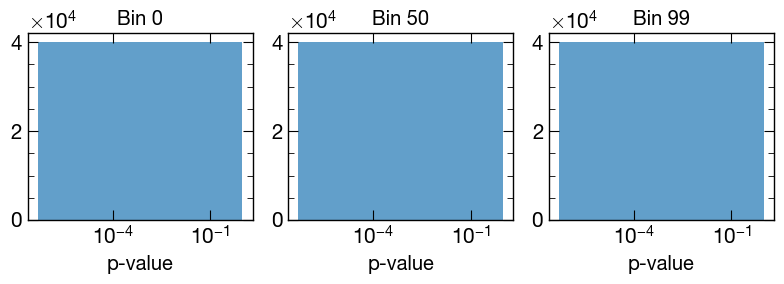

In [15]:
selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[j].set_xscale('log')
    axs[j].set_xlabel('p-value')

pf.fix_plot(axs)
plt.tight_layout()
plt.show()

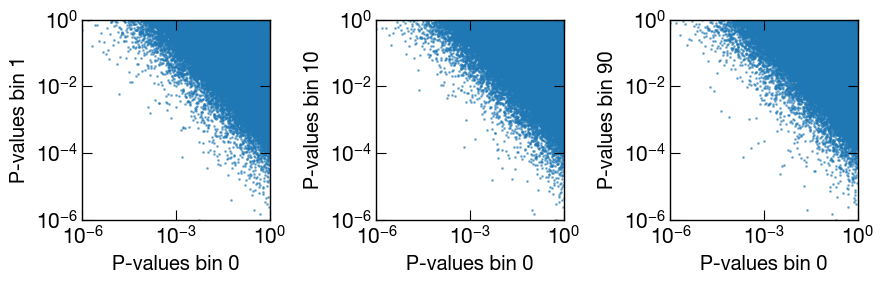

In [16]:
bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

pf.fix_plot(axs)
plt.tight_layout()
plt.show()

True

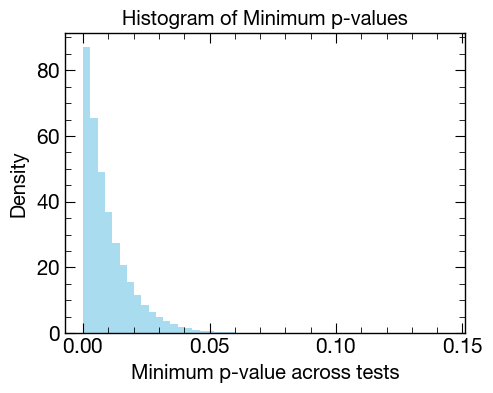

In [17]:
Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_epsilon = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

fig, ax1 = pf.create_plot(size=(4,3))
ax1.hist(min_pv_bin_H0_epsilon, bins=50, alpha=0.7, color='skyblue', density=True)
ax1.set_xlabel('Minimum p-value across tests')
ax1.set_ylabel('Density')
ax1.set_title('Histogram of Minimum p-values')
pf.fix_plot([ax1])

(1998848, 101)


True

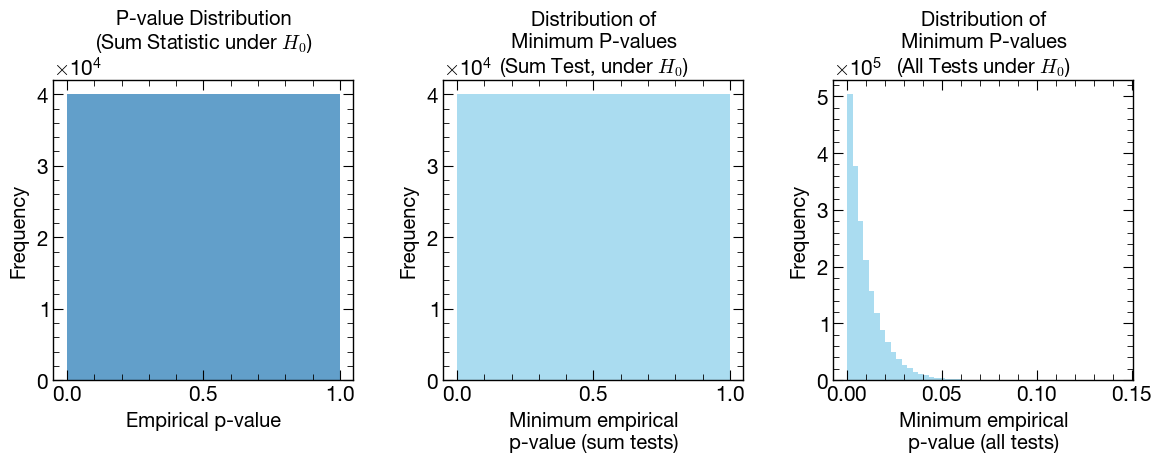

In [18]:
### - CENTER AND RANK TS_SUM UNDER H0 - ###
# Center the test statistic (e.g., chi-squared-like) under H0 by subtracting the mean
means = ts_sum_H0_epsilon.mean(axis=0)  # Mean of summed test statistic across MC samples
ts_centered = ts_sum_H0_epsilon - means  # Centered statistic

# Sort and rank the centered values to compute empirical p-values
sorted_ts = np.sort(ts_centered, axis=0)
ranks = np.argsort(np.argsort(-ts_centered, axis=0))  # Descending ranks
p_values = (ranks + 1) / N_mc  # Empirical p-values

pv_sum_H0 = p_values  # Final p-values for the sum test
pv_sum_H0.shape  # Check shape, should be (N_mc,)

### - PLOT HISTOGRAM OF EMPIRICAL P-VALUES - ###
fig,ax1=pf.create_plot(size=(3,3))
ax1.hist(pv_sum_H0, bins=50, alpha=0.7)
ax1.set_xlabel('Empirical p-value')
ax1.set_ylabel('Frequency')
ax1.set_title("P-value Distribution\n"+r"(Sum Statistic under $H_0$)")

# This shows the distribution of the p-values under H0 for the sum test

############### THIS COULD BE A MISTAKE REPEAT PLOT ######################
### - PLOT MINIMUM P-VALUES FROM SUM TEST - ###
min_pv_sum_H0_epsilon = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)

ax2 = fig.add_axes((1.3,0,1,1))
ax2.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
ax2.set_xlabel('Minimum empirical\np-value (sum tests)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of\nMinimum P-values\n'+r'(Sum Test, under $H_0$)')
#########################################################################

### - COMBINE BIN-WISE AND SUM P-VALUES - ###
Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([
    pv_bin_H0.reshape(Nmc, -1),     # Bin-wise p-values
    pv_sum_H0.reshape(Nmc, -1)      # Sum p-values
], axis=1)  # Combined shape: [N_mc, N_bins + 1]

print(pv_all_H0.shape)  # Sanity check

### - PLOT MINIMUM P-VALUES ACROSS ALL TESTS - ###
min_pv_all_H0_epsilon = np.min(pv_all_H0, axis=1)  # Take minimum p-value across all bins + sum

ax3 = fig.add_axes((2.6,0,1,1))
ax3.hist(min_pv_all_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
ax3.set_xlabel('Minimum empirical\np-value (all tests)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of\nMinimum P-values\n'+'(All Tests under $H_0$)')

pf.fix_plot([ax1,ax2,ax3])

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from cycler import cycler

mygold = (218/255, 165/255, 64/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [20]:
def analyse_obs_epsilon(obs):
    
    target = obs['xi']
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    # epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]

    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
    # variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]

    snr2_nn = network_epsilon.snr(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    # snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]

    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   

    
    # Compute analytical epsilon and SNR^2 test statistic
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = (obs['xi'] - fit).to(dtype=torch.float32)
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() #((obs['xi'])**2/SIGMA**2).sum()
    p_sum_analytical = t_to_pvalue(ts_sum_analytical, DOF)

    # Compute localized p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)


    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_epsilon <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_epsilon <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    c = ["C0", "C1", "C2"]
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color = mycolors[1], ls= (0, (1, 1)), label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")
    # ax1.set_xlabel("$i$", labelpad=1.5)


    # Second column: ax2 and ax3 in the first column c = mycolor[1]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c = mycolors[1], label=r"$\mathrm{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)
    # ax2.set_xlabel("$i$", labelpad=1.5)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, epsilon_nn, c = mycolors[1], label=r"$\mathrm{SBI}$")
    ax3.plot(grid, epsilon_analytical, c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    # ax3.set_xlabel("$i$", labelpad=1.5)
    ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])
    ax3.set_title("Residual analysis")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor = mycolors[1], edgecolor = mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    ax6.hist(epsilon_nn / np.sqrt(variance_nn), bins=bins, density=True, color = mycolors[1], alpha=0.5)
    ax6.hist(epsilon_analytical, bins=bins, density=True, histtype='step', color='k', linestyle = 'dotted')
    ax6.set_xlim(-5*SIGMA, 5*SIGMA)
    ax6.set_xlabel("$\epsilon_\mathrm{obs}/\sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    axes = [ax1,ax2,ax3,ax4,ax6]
    pf.fix_plot(axes)

    plt.tight_layout();

<>:73: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:91: SyntaxWarning: invalid escape sequence '\m'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\e'
<>:73: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:91: SyntaxWarning: invalid escape sequence '\m'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\e'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/4061610990.py:73: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_9939/4061610990.py:78: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0]+dist, color = mycolors[1], ls=

the number of bins is 100


(np.float64(5.002879156954828e-07), np.float64(1.1102230246251565e-16))

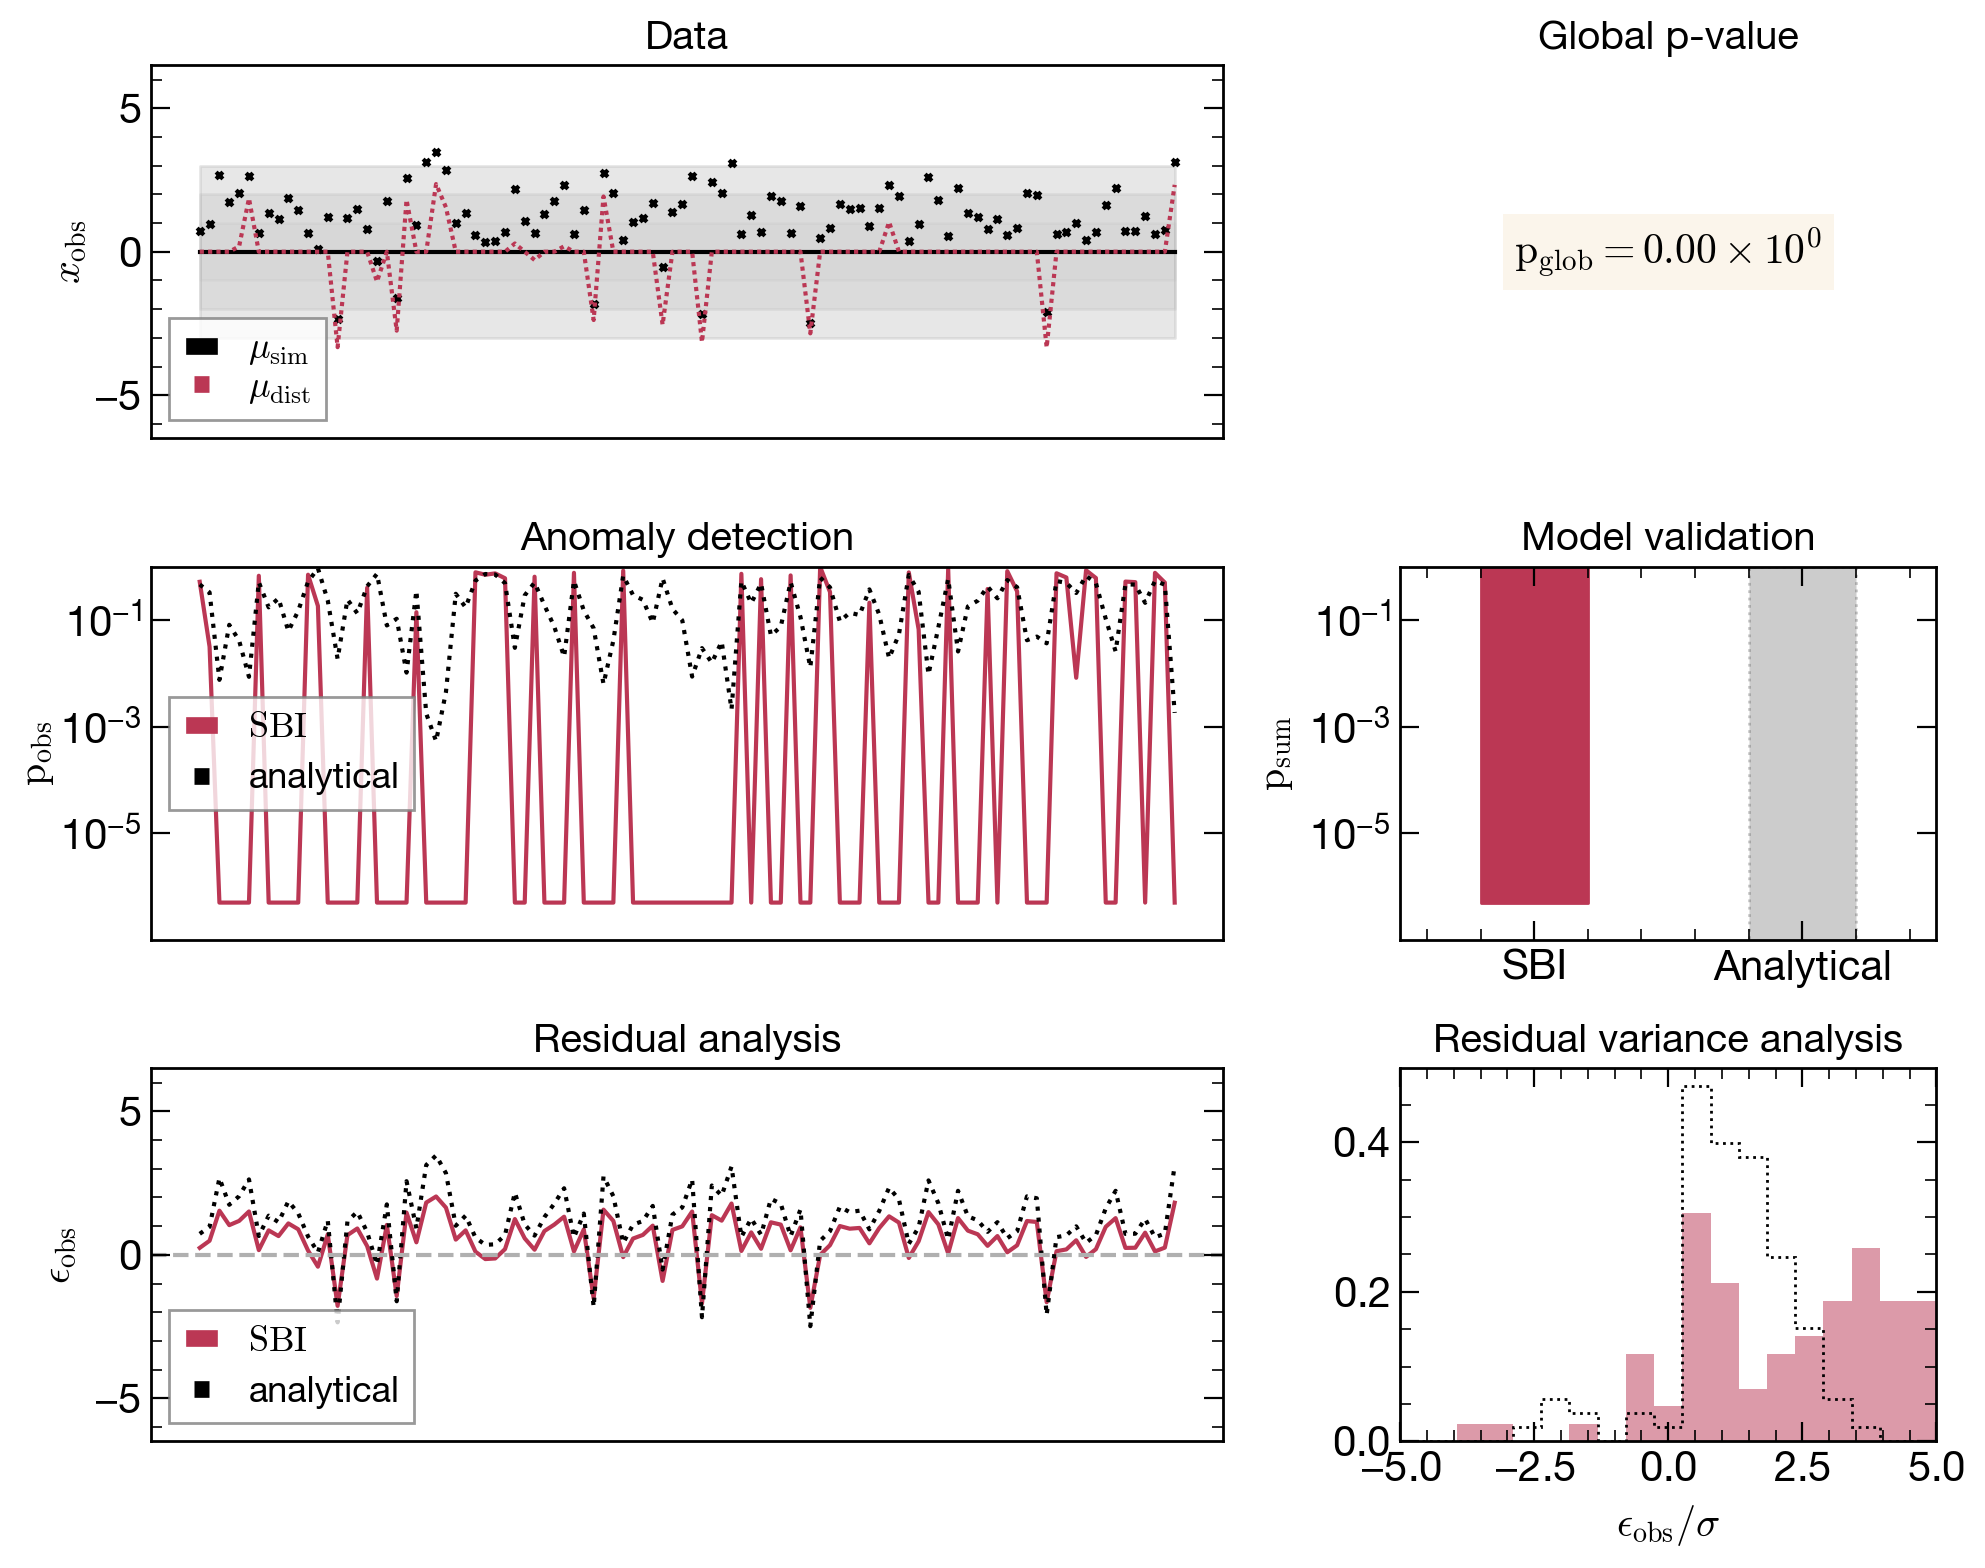

In [21]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.2, bkg=True, dtype=torch.float32, mode='complex')     
obs = simulator1.sample(1) 

epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)
plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn, p_sum_analytical

In [22]:
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)


the number of bins is 100


(np.float64(5.002879156954828e-07), np.float64(5.91554583095899e-11))

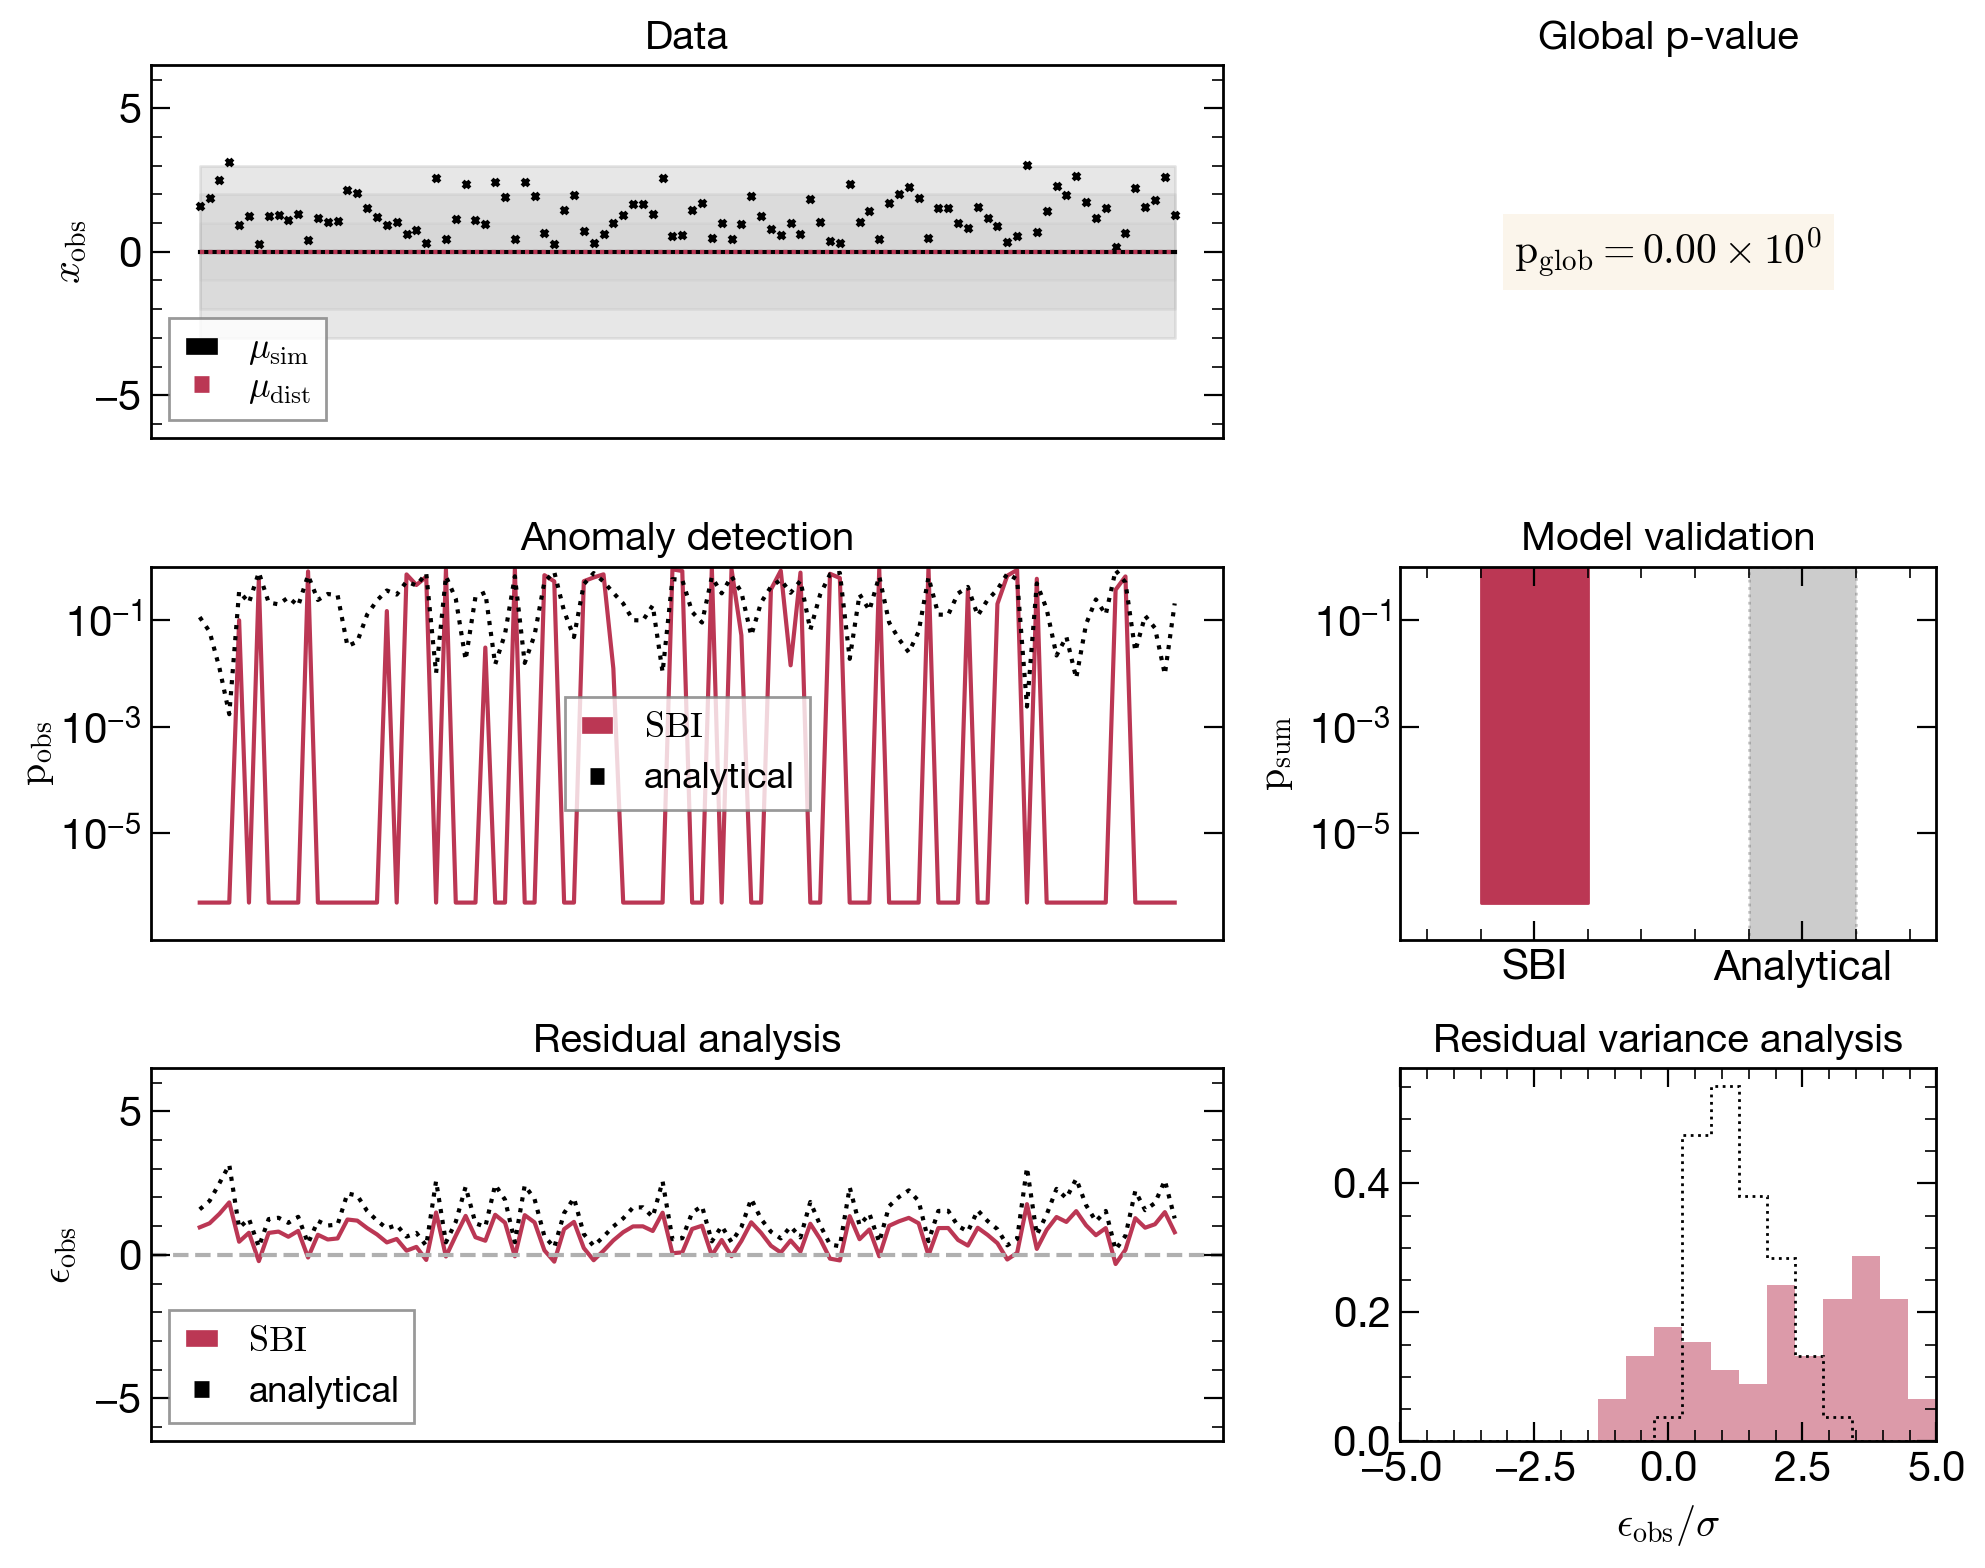

In [23]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0, bkg=True, dtype=torch.float32, mode='complex')     
obs = simulator1.sample(1) 

epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)
plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn, p_sum_analytical

In [24]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=1, bounds=5, fraction=0.2, bkg=True, dtype=torch.float32, mode='complex')     

N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
data_bin_H0 = []
eps_bin_H0 = [] 
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    data_bin_H0.append(mc_samples['x0'])
    eps_bin_H0.append(mc_samples['epsilon'])
    
data_bin_H0 = np.concatenate(data_bin_H0)
eps_bin_H0 = np.concatenate(eps_bin_H0)

the number of bins is 100


100%|██████████| 488/488 [00:03<00:00, 127.49it/s]


True

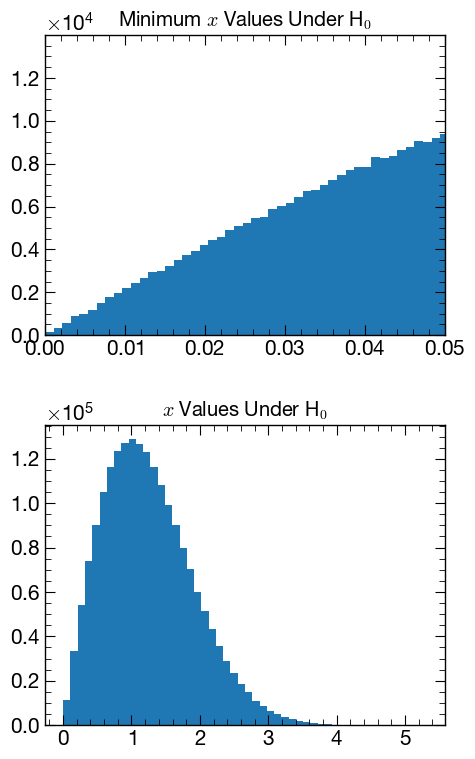

In [33]:
fig, ax1 = pf.create_plot()
min_values = np.min(data_bin_H0, axis=1)
ax1.hist(min_values, bins=500)
# ax1.set_xscale('log')
ax1.set_xlim(0,0.05)
ax1.set_title(r'Minimum $x$ Values Under H$_0$')


ax2 = fig.add_axes((0,-1.3,1,1))
ax2.set_title(r'$x$ Values Under H$_0$')

ax2.hist(data_bin_H0[:,0], bins=50)

pf.fix_plot([ax1,ax2])


In [26]:
print(np.sum(data_bin_H0>1))
simulator.sample(1)

121244496


{'theta': tensor([[-0.0649,  0.1046,  0.8140]]),
 'mu': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]),
 'x0': tensor([[0.7817, 2.6086, 0.3875, 1.8094, 1.2144, 0.2228, 1.3096, 1.0774, 0.5690,
          1.0097, 2.2638, 0.9723, 1.0562, 1.7330, 0.8034, 0.5830, 0.6833, 0.7369,
          1.0351, 1.5029, 2.9452, 1.2142, 1.5768, 1.0900, 1.7821, 1.4311, 0.5049,
          2.0381, 0.8275, 1.3606, 0.8084, 1.6268, 0.7793, 0.2106, 0.5435, 0.6548,
          2.3839, 1.7564, 2.5186, 2.2883, 0.6850, 2.9097, 0.3046, 0.8657, 2.2726,
          1.4179, 1.7470, 0.4893, 0.2087, 2.1214, 1.3224, 1.9471, 0.4556, 0.